In [39]:
from spatial_filtering import arrays, constants, simulation
import numpy as np
import matplotlib.pyplot as plt

import importlib

importlib.reload(arrays)
importlib.reload(constants)
importlib.reload(simulation)

num_antenna = 37
num_frequencies = 10
f_base = 1e9
f_diff = 1e7

f = np.array([f_base + n * f_diff for n in range(num_frequencies)])
wv = constants.c / f
d  = 1 * wv[0]/2

theta_signal_deg = [40, 41, 42, 43, 43.5]

array = arrays.UniformLinearArray(num_antenna, d)

t = np.linspace(0, 10, 1000)


data = np.array([simulation.simulate_linear_array(array, freq, theta_signal_deg, 10, t, sigma=0) for freq in f])


In [40]:
from tqdm import tqdm

theta_range = np.linspace(40, 44, 100000)


output = []

acms = []

for channel in range(data.shape[0]):
    acm = data[channel, :, :] @ data[channel, :, :].conj().T / (num_antenna - 1)

    evals, evecs = np.linalg.eigh(acm)

    
    
    assert len(evals) == num_antenna
    num_interferers = 5

    noise_matrix = evecs[:, :-num_interferers] @ evecs[:, :-num_interferers].conj().T
    acms.append(noise_matrix)


for theta in tqdm(theta_range):
    Q_sum = 1
    for channel in range(data.shape[0]):
        steer_vec = array.steering_vector(np.deg2rad(theta), wv[channel]).T
        Q_sum *= 1/np.abs(steer_vec.conj().T @ acms[channel]  @ steer_vec)
    Q = Q_sum
    output.append(Q)
output = np.array(output)
output = 10 * np.log10(np.abs(output) / np.max(np.abs(output))) # convert to dB

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:26<00:00, 681.86it/s]


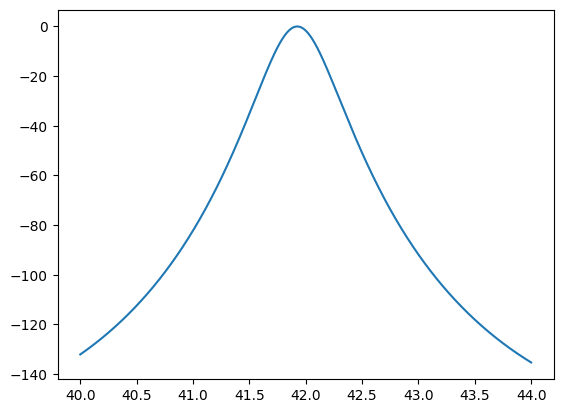

In [41]:
plt.plot(theta_range, output)